In [1]:
import os
from pathlib import Path
import sys
import logging

logging.basicConfig(level=logging.INFO)


In [2]:
sys.path.append('..')


In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, TensorDataset


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp01cd8wte
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp01cd8wte/_remote_module_non_scriptable.py


In [5]:
import baard.utils.torch_utils as utils
from baard.classifiers import CIFAR10_ResNet18


In [6]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
PATH_CHECKPOINT = os.path.join(PATH_ROOT, 'pretrained_clf')
print('ROOT:', PATH_ROOT)
print('CHECKPOINT:', PATH_CHECKPOINT)


ROOT: /home/lukec/workspace/baard_v4
CHECKPOINT: /home/lukec/workspace/baard_v4/pretrained_clf


In [7]:
path_checkpoint = os.path.join(PATH_CHECKPOINT, 'cifar10_resnet18.ckpt')
model = CIFAR10_ResNet18.load_from_checkpoint(path_checkpoint)


In [8]:
path_val = os.path.join(PATH_ROOT, 'results', 'exp1234', 'CIFAR10', 'ValClean-1000.pt')
path_clean = os.path.join(PATH_ROOT, 'results', 'exp1234', 'CIFAR10', 'AdvClean-100.pt')

X_val, y_val = utils.dataset2tensor(torch.load(path_val))
X_clean, y_clean = utils.dataset2tensor(torch.load(path_clean))

print(X_val.shape, X_clean.shape)


torch.Size([1000, 3, 32, 32]) torch.Size([100, 3, 32, 32])


In [9]:
print('True:', y_clean[:10])
_pred = torch.argmax(model(X_clean[:10]), 1)
print('Pred:', _pred)


True: tensor([2, 1, 7, 4, 7, 2, 6, 1, 9, 2])
Pred: tensor([2, 1, 7, 4, 7, 0, 6, 1, 9, 2])


In [10]:
from baard.attacks.adaptive_whitebox import targeted_whitebox_pgd


In [11]:
# Find the nearest example with a different label in the validation set.
indices_target = torch.where(y_val != y_clean[0])[0]
X_target = X_val[indices_target]
y_target = y_val[indices_target]

cosine_sim_fn = torch.nn.CosineSimilarity(dim=1)
cos_sim_target = cosine_sim_fn(
    X_target.reshape(len(X_target), -1),
    X_clean[0].flatten(),
)
angular_dist_target = torch.arccos(cos_sim_target) / torch.pi
idx_nearest = torch.argmin(angular_dist_target)
print('Mean: {:.3f} Dist: {:.3f}, Idx: {}'.format(
    angular_dist_target.mean(),
    angular_dist_target[idx_nearest],
    idx_nearest
))


Mean: 0.166 Dist: 0.091, Idx: 317


In [12]:
x_near_target = X_target[idx_nearest]
y_near_target = y_target[idx_nearest]
print(y_near_target)


tensor(8)


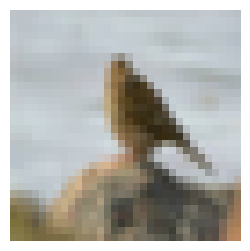

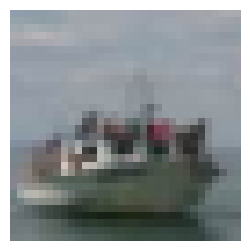

tensor(2) tensor(8)


In [13]:
utils.show_img(X_clean[0])
utils.show_img(X_target[idx_nearest])
print(y_clean[0], y_near_target)

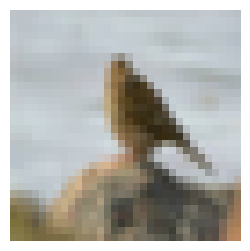

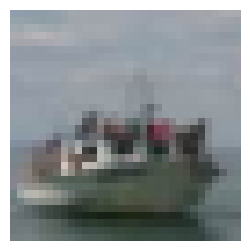

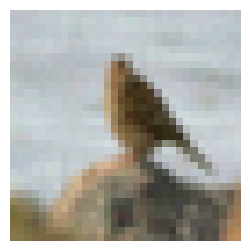

Pred: tensor([3])


In [14]:
X_adv = targeted_whitebox_pgd(
    model,
    X_clean[0].unsqueeze(0),
    X_target[idx_nearest].unsqueeze(0),
    eps=0.01,
    eps_iter=0.01,
    nb_iter=100,
    norm=np.inf,
    early_stop=False,
)
utils.show_img(X_clean[0])
utils.show_img(X_target[idx_nearest])
utils.show_img(X_adv[0])
print('Pred:', torch.argmax(model(X_adv), 1))


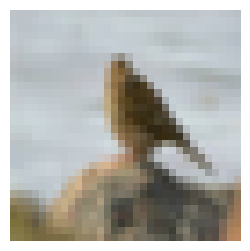

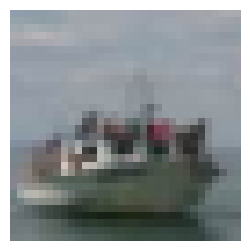

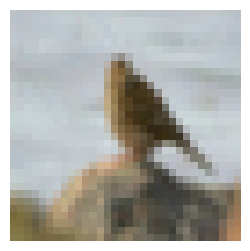

Pred: tensor([3])


In [15]:
# With larger c value. More weight toward the targeted example.
X_adv = targeted_whitebox_pgd(
    model,
    X_clean[0].unsqueeze(0),
    X_target[idx_nearest].unsqueeze(0),
    eps=0.3,
    eps_iter=0.05,
    nb_iter=100,
    norm=2,
    early_stop=False,
    c=10,
)
utils.show_img(X_clean[0])
utils.show_img(X_target[idx_nearest])
utils.show_img(X_adv[0])
print('Pred:', torch.argmax(model(X_adv), 1))


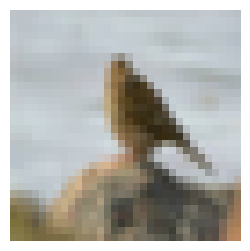

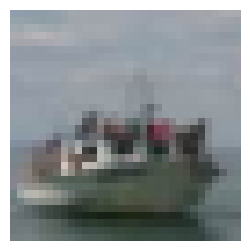

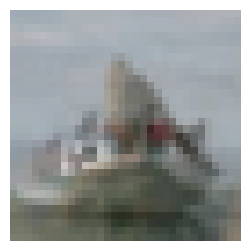

Pred: tensor([3])


In [23]:
# Try large Eps
X_adv = targeted_whitebox_pgd(
    model,
    X_clean[0].unsqueeze(0),
    X_target[idx_nearest].unsqueeze(0),
    eps=8,
    eps_iter=0.05,
    nb_iter=500,
    norm=2,
    early_stop=False,
    c=100,
)
utils.show_img(X_clean[0])
utils.show_img(X_target[idx_nearest])
utils.show_img(X_adv[0])
print('Pred:', torch.argmax(model(X_adv), 1))